# Overview
Rather than trying to segment, we start off by making a model that simply tries to identify if any boat shows up in the image. 
For this model we can see roughly how it performs in the compititon by guessing the whole image (as an RLE) if any boat shows up (not a very smart startegy, but might provide some interesting results). 

## Beyond
The model could also be useful as a quick way (low resolution images) to screen through lots of images to see if they are likely to have a boat and if they are then run a much more expensive full-resolution U-Net on that sample

## Model Parameters
We might want to adjust these later (or do some hyperparameter optimizations). It is slightly easier to keep track of parallel notebooks with different parameters if they are all at the beginning in a clear (machine readable format, see Kaggling with Kaggle (https://www.kaggle.com/kmader/kaggling-with-kaggle).

In [1]:
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# number of validation images to use
VALID_IMG_COUNT = 1000
# maximum number of training images
MAX_TRAIN_IMAGES = 150000000 
BASE_MODEL='DenseNet169' # ['VGG16', 'RESNET52', 'InceptionV3', 'Xception', 'DenseNet169', 'DenseNet121']
IMG_SIZE = (299, 299) # [(224, 224), (384, 384), (512, 512), (640, 640)]
BATCH_SIZE = 64 # [1, 8, 16, 24]
DROPOUT = 0.5
DENSE_COUNT = 128
LEARN_RATE = 1e-4
RGB_FLIP = 1 # should rgb be flipped when rendering images

In [2]:
!pip install scikit-image

You are using pip version 9.0.3, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
from skimage.util._montage import montage2d as montage
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

COMPETITION_NAME= 'airbus-ship-detection'
PATH = os.path.expanduser(f"~/.kaggle/competitions/{COMPETITION_NAME}")

ship_dir = PATH
train_image_dir = os.path.join(ship_dir, 'train')
test_image_dir = os.path.join(ship_dir, 'test')
import gc; gc.enable() # memory is tight

In [4]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks['path'] = masks['ImageId'].map(lambda x: os.path.join(train_image_dir, x))
masks.head()

131030 masks found
104070


,ImageId,EncodedPixels,path
0,00003e153.jpg,NaN,/home/ubuntu/.kaggle/competitions/airbus-ship-...
1,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,/home/ubuntu/.kaggle/competitions/airbus-ship-...
2,00021ddc3.jpg,101361 1 102128 3 102896 4 103663 6 104430 9 1...,/home/ubuntu/.kaggle/competitions/airbus-ship-...
3,00021ddc3.jpg,95225 2 95992 5 96760 7 97527 9 98294 9 99062 ...,/home/ubuntu/.kaggle/competitions/airbus-ship-...
4,00021ddc3.jpg,74444 4 75212 4 75980 4 76748 4 77517 3 78285 ...,/home/ubuntu/.kaggle/competitions/airbus-ship-...


# Split into training and validation groups
We stratify by the number of boats appearing so we have nice balances in each set

In [5]:
from sklearn.model_selection import train_test_split
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
masks.drop(['ships'], axis=1, inplace=True)
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])
train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)
print(train_df.shape[0], 'training masks')
print(valid_df.shape[0], 'validation masks')

91709 training masks
39321 validation masks


### Examine Number of Ship Images
Here we examine how often ships appear and replace the ones without any ships with 0

In [6]:
train_df = train_df.sample(min(MAX_TRAIN_IMAGES, train_df.shape[0])) # limit size of training set (otherwise it takes too long)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f79e2a206a0>,
      dtype=object)

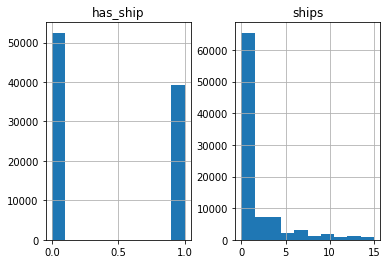

In [7]:
train_df[['ships', 'has_ship']].hist()

# Augment Data

In [9]:
BASE_MODEL

'DenseNet169'

In [8]:
from keras.preprocessing.image import ImageDataGenerator
if BASE_MODEL=='VGG16':
    from keras.applications.vgg16 import VGG16 as PTModel, preprocess_input
elif BASE_MODEL=='RESNET52':
    from keras.applications.resnet50 import ResNet50 as PTModel, preprocess_input
elif BASE_MODEL=='InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as PTModel, preprocess_input
elif BASE_MODEL=='Xception':
    from keras.applications.xception import Xception as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet169': 
    from keras.applications.densenet import DenseNet169 as PTModel, preprocess_input
elif BASE_MODEL=='DenseNet121':
    from keras.applications.densenet import DenseNet121 as PTModel, preprocess_input
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
from keras.preprocessing.image import ImageDataGenerator
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 45, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  brightness_range = [0.5, 1.5],
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last',
              preprocessing_function = preprocess_input)
valid_args = dict(fill_mode = 'reflect',
                   data_format = 'channels_last',
                  preprocessing_function = preprocess_input)

core_idg = ImageDataGenerator(**dg_args)
valid_idg = ImageDataGenerator(**valid_args)

In [11]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    print('## Ignore next message from keras, values are replaced anyways')
    df_gen = img_data_gen.flow_from_directory(base_dir, 
                                     class_mode = 'sparse',
                                    **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = '' # since we have the full path
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    return df_gen

In [12]:
train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE)

# used a fixed dataset for evaluating the algorithm
valid_x, valid_y = next(flow_from_dataframe(valid_idg, 
                               valid_df, 
                             path_col = 'path',
                            y_col = 'has_ship_vec', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = VALID_IMG_COUNT)) # one big batch
print(valid_x.shape, valid_y.shape)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 91709 images
## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 39321 images
(1000, 299, 299, 3) (1000, 1)


x (64, 299, 299, 3) float32 -2.117904 2.64
y (64, 1) float64 0.0 1.0


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,


Text(0.5,1,'ships')

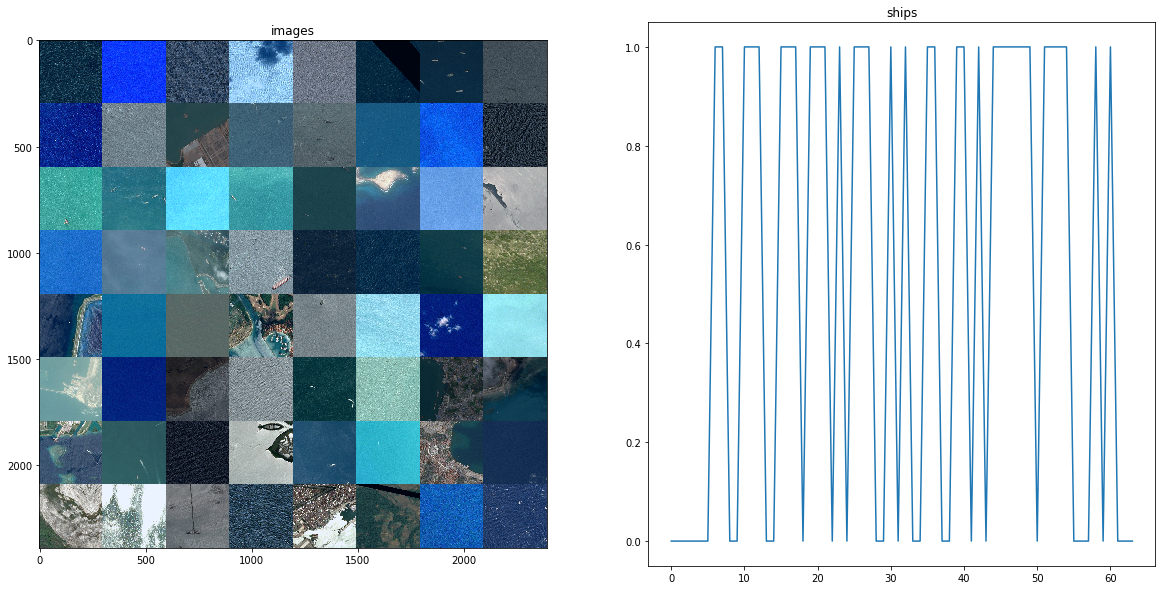

In [13]:
t_x, t_y = next(train_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, ::RGB_FLIP], cmap='gray')
ax1.set_title('images')
ax2.plot(t_y)
ax2.set_title('ships')

# Build a Model
We build the pre-trained top model and then use a global-max-pooling (we are trying to detect any ship in the image and thus max is better suited than averaging (which would tend to favor larger ships to smaller ones). 

In [14]:
base_pretrained_model = PTModel(input_shape =  t_x.shape[1:], 
                              include_top = False, weights = 'imagenet')
base_pretrained_model.trainable = False

## Setup the Subsequent Layers
Here we setup the rest of the model which we will actually be training

In [15]:
from keras import models, layers
from keras.optimizers import Adam
img_in = layers.Input(t_x.shape[1:], name='Image_RGB_In')
img_noise = layers.GaussianNoise(GAUSSIAN_NOISE)(img_in)
pt_features = base_pretrained_model(img_noise)
pt_depth = base_pretrained_model.get_output_shape_at(0)[-1]
bn_features = layers.BatchNormalization()(pt_features)
feature_dropout = layers.SpatialDropout2D(DROPOUT)(bn_features)
gmp_dr = layers.GlobalMaxPooling2D()(feature_dropout)
dr_steps = layers.Dropout(DROPOUT)(layers.Dense(DENSE_COUNT, activation = 'relu')(gmp_dr))
out_layer = layers.Dense(1, activation = 'sigmoid')(dr_steps)

ship_model = models.Model(inputs = [img_in], outputs = [out_layer], name = 'full_model')

ship_model.compile(optimizer = Adam(lr=LEARN_RATE), 
                   loss = 'binary_crossentropy',
                   metrics = ['binary_accuracy'])

ship_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Image_RGB_In (InputLayer)    (None, 299, 299, 3)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 299, 299, 3)       0         
_________________________________________________________________
densenet169 (Model)          (None, 9, 9, 1664)        12642880  
_________________________________________________________________
batch_normalization_1 (Batch (None, 9, 9, 1664)        6656      
_________________________________________________________________
spatial_dropout2d_1 (Spatial (None, 9, 9, 1664)        0         
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               213120    
__________

In [16]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('boat_detector')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/keras/callbacks.py:928: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` insted.
  warnings.warn('`epsilon` argument is deprecated and '


In [19]:
train_gen.batch_size = BATCH_SIZE
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


ship_model.fit_generator(train_gen, 
                      validation_data = (valid_x, valid_y), 
                      epochs = 30, 
                      callbacks = callbacks_list,
                      workers = 6)

Epoch 1/30
1433/1433 [==============================] - 1693s 1s/step - loss: 0.4223 - binary_accuracy: 0.8089 - val_loss: 0.3909 - val_binary_accuracy: 0.8210

Epoch 00001: val_loss improved from inf to 0.39093, saving model to boat_detector_weights.best.hdf5
Epoch 2/30
1433/1433 [==============================] - 1616s 1s/step - loss: 0.3872 - binary_accuracy: 0.8293 - val_loss: 0.3691 - val_binary_accuracy: 0.8350

Epoch 00002: val_loss improved from 0.39093 to 0.36914, saving model to boat_detector_weights.best.hdf5
Epoch 3/30
1433/1433 [==============================] - 1604s 1s/step - loss: 0.3700 - binary_accuracy: 0.8381 - val_loss: 0.4413 - val_binary_accuracy: 0.8100

Epoch 00003: val_loss did not improve from 0.36914
Epoch 4/30
1433/1433 [==============================] - 1602s 1s/step - loss: 0.3584 - binary_accuracy: 0.8435 - val_loss: 0.3814 - val_binary_accuracy: 0.8410

Epoch 00004: val_loss did not improve from 0.36914
Epoch 5/30
1433/1433 [============================

In [21]:
ship_model.load_weights(weight_path)
ship_model.save('full_ship_model.h5')

# Run the test data
We use the sample_submission file as the basis for loading and running the images.

In [22]:
test_paths = os.listdir(test_image_dir)
print(len(test_paths), 'test images found')
submission_df = pd.read_csv(f'{PATH}/sample_submission.csv')
submission_df['path'] = submission_df['ImageId'].map(lambda x: os.path.join(test_image_dir, x))

88500 test images found


# Setup Test Data Generator
We use the same generator as before to read and preprocess images

In [23]:
test_gen = flow_from_dataframe(valid_idg, 
                               submission_df, 
                             path_col = 'path',
                            y_col = 'ImageId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE, 
                              shuffle = False)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 88486 images


/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function ``montage2d`` is deprecated and will be removed in version 0.15. Use ``montage`` instead.
  def montage2d(arr_in, fill='mean', rescale_intensity=False, grid_shape=None,
/home/ubuntu/anaconda3/envs/fastai/lib/python3.6/site-packages/skimage/util/_montage.py:142: skimage_deprecation: Function `

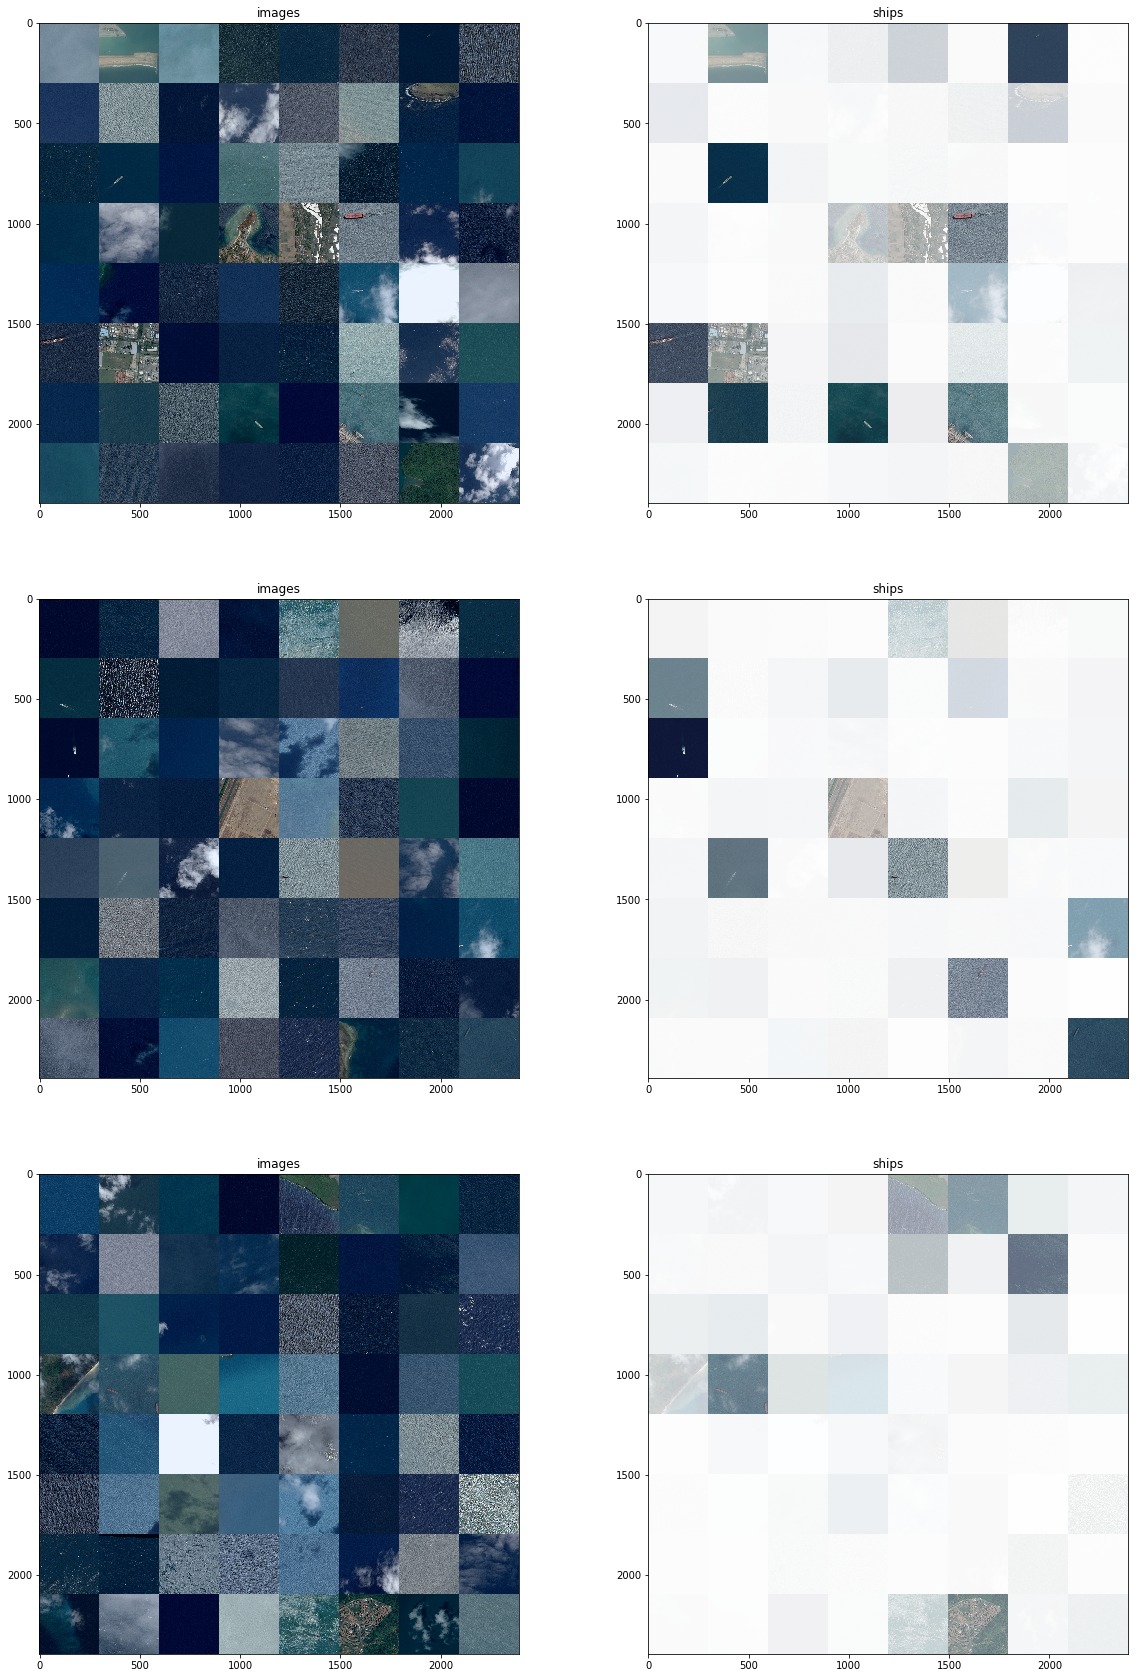

In [24]:
fig, m_axs = plt.subplots(3, 2, figsize = (20, 30))
for (ax1, ax2), (t_x, c_img_names) in zip(m_axs, test_gen):
    t_y = ship_model.predict(t_x)
    t_stack = ((t_x-t_x.min())/(t_x.max()-t_x.min()))[:, :, :, ::RGB_FLIP]
    ax1.imshow(montage_rgb(t_stack))
    ax1.set_title('images')
    alpha_stack = np.tile(np.expand_dims(np.expand_dims(t_y, -1), -1), [1, t_stack.shape[1], t_stack.shape[2], 1])
    rgba_stack = np.concatenate([t_stack, alpha_stack], -1)
    ax2.imshow(montage_rgb(rgba_stack))
    ax2.set_title('ships')
fig.savefig('test_predictions.png')

# Prepare Submission
Process all images (batchwise) and keep the score at the end

In [25]:
BATCH_SIZE = BATCH_SIZE*2 # we can use larger batches for inference
test_gen = flow_from_dataframe(valid_idg, 
                               submission_df, 
                             path_col = 'path',
                            y_col = 'ImageId', 
                            target_size = IMG_SIZE,
                             color_mode = 'rgb',
                            batch_size = BATCH_SIZE, 
                              shuffle = False)

## Ignore next message from keras, values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: 88486 images


In [26]:
from tqdm import tqdm_notebook
all_scores = dict()
for _, (t_x, t_names) in zip(tqdm_notebook(range(test_gen.n//BATCH_SIZE+1)),
                            test_gen):
    t_y = ship_model.predict(t_x)[:, 0]
    for c_id, c_score in zip(t_names, t_y):
        all_scores[c_id] = c_score

# Show the Scores
Here we see the scores and we have to decide about a cut-off for counting an image as ship or not. We can be lazy and pick 0.5 but some more rigorous cross-validation would definitely improve this process.

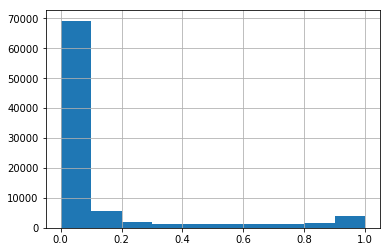

In [27]:
submission_df['score'] = submission_df['ImageId'].map(lambda x: all_scores.get(x, 0))
submission_df['score'].hist()

# Make the RLE data if there is a ship
Here we make the RLE data for a positive image (assume every pixel is ship)

(768, 768)
7691 748 8459 748 9227 748 9995 748 10763 748 1153


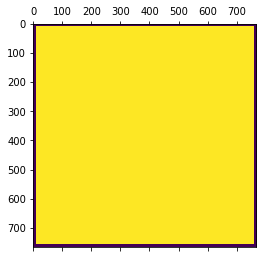

In [28]:
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
# empty image
zp_dim = 10
out_img = np.ones((768-2*zp_dim, 768-2*zp_dim), dtype=bool)
out_img = np.pad(out_img, ((zp_dim, zp_dim),), mode='constant', constant_values=0)
plt.matshow(out_img)
print(out_img.shape)
pos_ship_str = rle_encode(out_img)
print(pos_ship_str[:50])

In [29]:
# add the whole image if it is above the threshold
submission_df['EncodedPixels'] = submission_df['score'].map(lambda x: pos_ship_str if x>0.5 else None)

In [30]:
out_df = submission_df[['ImageId', 'EncodedPixels']]
out_df.to_csv('submission.csv', index=False)
out_df.head(20)

,ImageId,EncodedPixels
0,0001124c7.jpg,None
1,000194a2d.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
2,0001b1832.jpg,None
3,00052ed46.jpg,None
4,000532683.jpg,None
5,000592296.jpg,None
6,0005d6d95.jpg,7691 748 8459 748 9227 748 9995 748 10763 748 ...
7,000805313.jpg,None
8,000913daf.jpg,None
9,000952d51.jpg,None


In [32]:
!kaggle competitions submit -f submission.csv -m "transfer learning detect ship. if ship , give whole image" \
-q -c "airbus-ship-detection"

Successfully submitted to Airbus Ship Detection Challenge